<p align="center">
    <img src="https://github.com/TUIlmenauAMS/ADSP_Tutorials/blob/master/images/adsp_logo.png?raw=1">
</p>

### Prof. Dr. -Ing. Gerald Schuller <br> Jupyter Notebook: Renato Profeta


# Companding

In [ ]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/ASTD7vkgaKM" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

This is a scheme to make the SNR less dependent on the signal size.

This is a synonym for compression and expanding. Uniform quantization can be seen as a quantization value which is constant on the absolute scale. Non-uniform quantization, using companding, can be seen as having step sizes which stay constant relative to the amplitude, their step size grows with the amplitude.
    
We obtain this non-uniform quantization by first applying a non-linear function to the signal (to boost small values), and then apply a uniform quantizer. On the decoding side we first apply the de-quantizer, and then the inverse non-linear function (we reduce small values again to restore their original size).

<center>
    <img src="https://github.com/TUIlmenauAMS/ADSP_Tutorials/blob/master/images/companding_block.png?raw=1" width="500">
</center>

The range of (index) values is compressed, smaller values become larger, large values don't grow as fast. The following functions are standardized as “$\mu$-Law” and “A-Law”:

<center>
    <img src="https://github.com/TUIlmenauAMS/ADSP_Tutorials/blob/master/images/mu_law.png?raw=1" width="600">
    <img src="https://github.com/TUIlmenauAMS/ADSP_Tutorials/blob/master/images/mu_law_graph.png?raw=1" width="600">
</center>
<font size="2">      
 (From: http://www.dspguide.com/ch22/5.htm)
</font>

This “**compression**” function is applied **before a uniform quantizer** in the **encoder**. In the decoder, after uniform reverse quantisation, the inverse function is applied, turning y back into x.

Observe that these equations assume that we first normalize our signal and keep its sign separate.

In [ ]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/xRzq-NHOVJY" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

**Example:** For $\mu=255$ (which is used in the standard) and an $x$ with a maximum amplitude  of A, hence $-A \leq x \leq A$ we obtain:

$$ \large
y=sign(x) \cdot {\frac{\ln \left(1+255 \cdot \left| \left( \dfrac{x}{A}\right) \right| \right)}  {ln(1+255)} }$$

In the example of 8-bit mu-law PCM the quantization **index** is then (for a Mid-Tread quantizer following this compression function):

$$\large
index=round\left( \dfrac{y}{\Delta} \right)$$

Here, y has the range of -1,...,+1. Hence the quantization step size for 8 bits is:

$$\large
\Delta=\dfrac{(1-(-1))}{ 2^8 }=\dfrac{2}{ 2^8 }=\dfrac{1}{2^{ 7 }}$$

The index is then encoded as an 8 bit **codeword**.

In the **decoder** we compute the de-quantized y from a Mid-Tread de-quantizer, including its sign from the index,

$$y_{rek}=index \cdot q$$

and we compute the inverse compression function, the “**expanding**” function (hence the name “**companding**”)
We obtain the inverse through the following steps,

$$ \large
\mid{(y)}\mid= {\frac{\ln \left(1+255 \cdot \left| \left( \frac{x}{A}\right)\right|\right)}  {\ln(1+255)} }
$$

$$ \large
\mid y\mid \cdot \ln(256)= \ln \left(1+ 255 \cdot \left| \frac{x}{A} \right|\right)$$

$$ \large
\rightarrow e^{   \ln(256) \cdot \mid y\mid}=e^{1+255 \cdot \frac{\mid x\mid}{A}}
$$

$$ \large
\rightarrow \frac{(256^{\mid y \mid} -1)}{255 } \cdot A = \mid{ x}\mid
$$

$$ \large
\rightarrow x= sign(y) \frac{(256^{\mid y \mid}-1)} {255 } \cdot A
$$


(in the decoder we replace $y$ by $y_{rek}$ and $x$ by $x_{rek}$). This x is now our **de-quantized** value or signal.

Observe that with this companding, the effective quantization step size remains approximately constant **relative** to the **signal amplitude**. Large signal components have large effective step sizes and hence larger quantization errors, small signals have smaller effective quantisation step sizes and hence smaller quantisation errors. In this way we get a more or less **constant SNR** over a wide range of **signal amplitudes**.

**Important point to remember:** this approach is **identical** to having **non-uniform quantization** step sizes, smaller step sizes at smaller signal values, and larger step sizes at larger signal values. The compression and expanding of the signal makes the uniform step sizes “look” relatively smaller to the signal, it has more quantization steps to cover. And this has the same effect as a smaller signal with smaller quantization steps.

## Python Example

In [ ]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/P1M7H06RgCs" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Signal Processing Parameters
Fs = 32000   # Sampling frequency
T=1/Fs       # Sampling Time

In [ ]:
# Input Signal
A=1
freq=500
n_period=2
period=np.round((1/freq)*n_period*Fs).astype(int)
t = np.arange(Fs+1)*T # Time vector
sinewave = A*np.sin(2*np.pi*freq*t)

In [ ]:
# Quantization and De-quantization
N=4
stepsize=(1.0-(-1.0))/(2**N)
#Compression
y=np.sign(sinewave)*(np.log(1+255*np.abs(sinewave)))/np.log(256)

#Encode
sinewave_quant_rise_ind=np.floor(y/stepsize)
sinewave_quant_tread_ind=np.round(y/stepsize)
#Decode
sinewave_quant_rise_rec=sinewave_quant_rise_ind*stepsize+stepsize/2
sinewave_quant_tread_rec=sinewave_quant_tread_ind*stepsize

#Expansion
sinewave_quant_rise_rec=np.sign(sinewave_quant_rise_rec)*(np.exp(np.log(256)*np.abs(sinewave_quant_rise_rec))-1)/255
sinewave_quant_tread_rec=np.sign(sinewave_quant_tread_rec)*(np.exp(np.log(256)*np.abs(sinewave_quant_tread_rec))-1)/255

In [ ]:
# Shape for plotting
t_quant=np.delete(np.repeat(t[:period+1],2),-1)
sinewave_quant_rise_rec_plot=np.delete(np.repeat(sinewave_quant_rise_rec[:period+1],2),0)
sinewave_quant_tread_rec_plot=np.delete(np.repeat(sinewave_quant_tread_rec[:period+1],2),0)

In [ ]:
# Quantization Error
quant_error_tread=sinewave_quant_tread_rec-sinewave
quant_error_rise=sinewave_quant_rise_rec-sinewave

Text(0, 0.5, 'Amplitude')

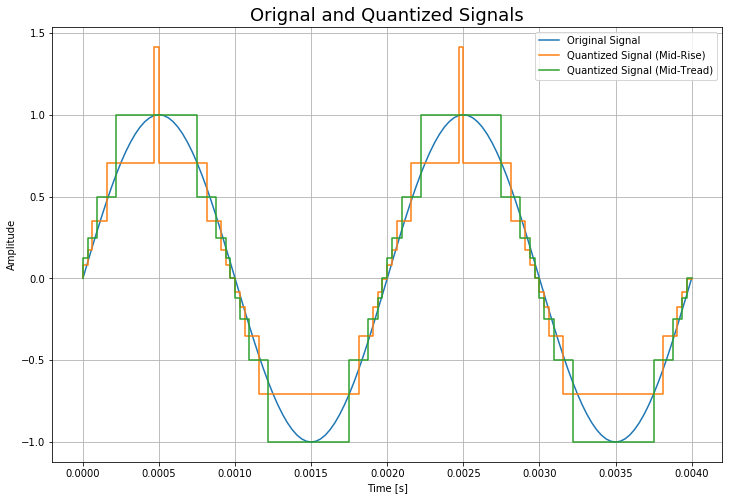

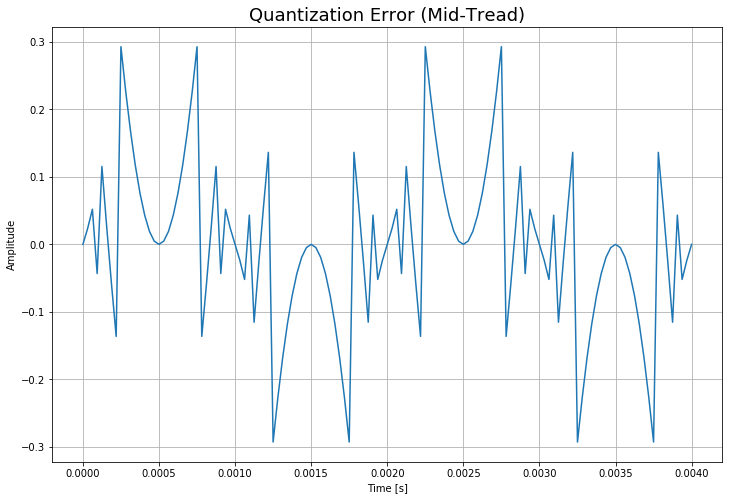

In [ ]:
# Plot
plt.figure(figsize=(12,8))
plt.plot(t[:period+1],sinewave[:period+1], label='Original Signal')
plt.plot(t_quant,sinewave_quant_rise_rec_plot, label='Quantized Signal (Mid-Rise)')
plt.plot(t_quant,sinewave_quant_tread_rec_plot, label='Quantized Signal (Mid-Tread)')
plt.title('Orignal and Quantized Signals', fontsize=18)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.figure(figsize=(12,8))
plt.plot(t[:period+1],quant_error_tread[:period+1], label='Quantization Error')
plt.grid()
plt.title('Quantization Error (Mid-Tread)', fontsize=18)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

In [ ]:
# Listen to Audio
import IPython.display as ipd
print('Orignal Signal')
ipd.display(ipd.Audio(sinewave, rate=Fs))
print('Quantized Signal (Mid-Tread)')
ipd.display(ipd.Audio(sinewave_quant_tread_rec, rate=Fs))
print('Quantized Signal (Mid-Rise)')
ipd.display(ipd.Audio(sinewave_quant_rise_rec, rate=Fs))
print('Quantization Error (Mid-Tread)')
ipd.display(ipd.Audio(quant_error_tread, rate=Fs))
print('Quantization Error (Mid-Rise)')
ipd.display(ipd.Audio(quant_error_rise, rate=Fs))

Orignal Signal


Quantized Signal (Mid-Tread)


Quantized Signal (Mid-Rise)


Quantization Error (Mid-Tread)


Quantization Error (Mid-Rise)


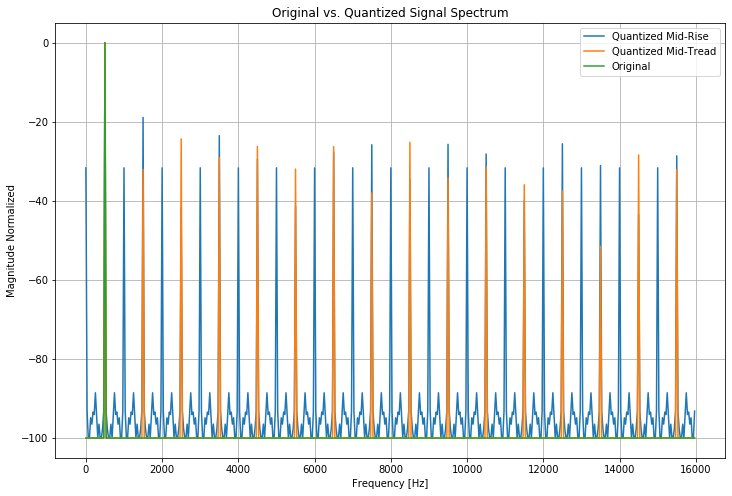

In [ ]:
# Imports
from scipy.fftpack import fft
import plotly.offline
import plotly.tools as tls
import plotly.plotly as py

# Configurations
plotly.offline.init_notebook_mode(connected=True)
import warnings; warnings.simplefilter('ignore')

# Signal Processing Parameters
NFFT=2**10
#Frequency Analysis
freqs = np.fft.fftfreq(NFFT, d=T) # Frequency bins
original_fft=fft(sinewave, n=NFFT)
original_fft/=np.abs(original_fft).max()
quantized_tread_fft=fft(sinewave_quant_tread_rec, n=NFFT)
quantized_tread_fft/=np.abs(quantized_tread_fft).max()
quantized_rise_fft=fft(sinewave_quant_rise_rec, n=NFFT)
quantized_rise_fft/=np.abs(quantized_rise_fft).max()

# Plot
fig=plt.figure(figsize=(12,8))
plt.plot(freqs[0:NFFT//2],20*np.log10(np.abs(quantized_rise_fft[0:NFFT//2]).clip(min=1e-5)), label='Quantized Mid-Rise')
plt.plot(freqs[0:NFFT//2],20*np.log10(np.abs(quantized_tread_fft[0:NFFT//2]).clip(min=1e-5)), label='Quantized Mid-Tread')
plt.plot(freqs[0:NFFT//2],20*np.log10(np.abs(original_fft[0:NFFT//2]).clip(min=1e-5)), label='Original')
plt.grid()
plt.title('Original vs. Quantized Signal Spectrum')
plt.ylabel('Magnitude Normalized')
plt.xlabel('Frequency [Hz]')
plt.legend();



#**Python Example: mu-law Quantization of a speech signal.**
We quantize a speech signal using mu-law quantization.

You can execute the real time python example with:

    python pyrecplay_mulawquantizationblock.py

(you might neet sudo apt install python-pyaudio),
or use a recording in the next cell.

The following is this quantization example here in Colab. Run these code cells:


In [ ]:
!pip install ffmpeg-python
!pip install PySoundFile
import soundfile as sf

In [ ]:
#@title Recording audio from microphone, run this setup: {display-mode: "form"}
"""
From:
https://colab.research.google.com/gist/ricardodeazambuja/03ac98c31e87caf284f7b06286ebf7fd/microphone-to-numpy-array-from-your-browser-in-colab.ipynb
Here are some of the possible references:
https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/
https://stackoverflow.com/a/18650249
https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/
https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/
https://stackoverflow.com/a/49019356
"""
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data);
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});

</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])

  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

  #Run this cell to record the audio:
audio, sr = get_audio()
print("sampling rate=", sr)
sf.write('sound.wav', audio, sr)

sampling rate= 48000


In [ ]:
#@title Run this cell to do the modulation:
import scipy.io.wavfile as wav
import numpy as np
from IPython.display import Audio, display

filename = '/content/sound.wav' #@param {'type': 'string'}
rate, snd = wav.read(filename)
print("Data Type:", snd.dtype, "rate=", rate)
samples=snd
#s=np.sin(2*np.pi/rate*500.0*np.arange(0,len(snd)));
#samples=snd*s #This is the modulation

###mu-Law compression:###
y=np.sign(samples)*(np.log(1+255*np.abs(samples/32768.0)))/np.log(256); #32768=2**15, 15 bits plus sign from the sound card

####Quantization, ####
#16 steps for normalized range -1<=x<=1 (4 bits), normalized range for the formula
q=2.0/16.0;
#Mid Tread quantization:
indices=np.round(y/q)
#Mid -Rise quantizer:
#indices=np.floor(y/q)

#### De-Quantization: #####
#Mit-Tread:
yrek=indices*q;
#Mid -Rise quantizer:
#yrek=indices*q+q/2;

#no quantization:
#yrek=y

#### mu-law expanding function: ###
#we use: exp(log(256)*yrek)=256^yrek
samples=np.sign(yrek)*(np.exp(np.log(256)*np.abs(yrek))-1)/255*32768.0
#end signal processing
samples=np.clip(samples,-32000,32000)

#Listen to it:
display(Audio(samples,rate=rate, autoplay=True))

Data Type: int16 rate= 48000


## Real-time $\mu$-Law Quantization Python Example

For this example to run you need to download this notebook to your local computer and run it with "jupyter notebook".

In [ ]:
"""
PyAudio Example: Make a quantization between input and output
(i.e., record a few samples, quatize them with a mid-tread or
mid-rise quantizer, and play them back immediately).
Using block-wise processing instead of a for loop
Gerald Schuller, Octtober 2014

Modified to Jupyter Notebook by Renato Profeta, October 2019
"""
# Imports
import pyaudio
import struct
import numpy as np
from ipywidgets import ToggleButton, Dropdown, Button, BoundedIntText, Label
from ipywidgets import HBox, interact, Checkbox
import threading

# Parameters
CHUNK = 5000 #Blocksize
FORMAT = pyaudio.paInt16 #conversion format for PyAudio stream
CHANNELS = 1
RATE = 32000  #Sampling Rate in Hz


# Quantization Bit-Depth
N=8
quant_type='Mid-Tread'
muLawOn=False

# Quantization Application
def quantization_example(toggle_run):
    global N, quant_type, muLaw
    while(True):
        if toggle_run.value==True:
            break
        #Reading from audio input stream into data with block length "CHUNK":
        data_stream = stream.read(CHUNK)
        #Convert from stream of bytes to a list of short integers
        #(2 bytes here) in "samples":
        shorts = (struct.unpack( 'h' * CHUNK, data_stream ));
        samples=np.array(list(shorts),dtype=float)

        #start block-wise signal processing:

        #Normalize
        samples/=2**15

        # Compression
        if muLawOn:
            samples=np.sign(samples)*(np.log(1+255*np.abs(samples)))/np.log(256)

        # Quantization Steps
        q=((1-(-1))/(2**N))

        if quant_type=='Mid-Tread':
            #Mid Tread quantization:
            indices=np.round(samples/q)
            #de-quantization:
            samples=indices*q
        else:
            #Mid -Rise quantizer:
            indices=np.floor(samples/q)
            #de-quantization:
            samples=(indices*q+q/2)
            #end signal processing

        # Expansion
        if muLawOn:
            samples=np.sign(samples)*(np.exp(np.log(256)*np.abs(samples))-1)/255

        # Back to 2**15
        samples*=2**15

        #converting from short integers to a stream of bytes in "data":
        #play out samples:
        samples=np.clip(samples, -32000,32000)
        samples=samples.astype(int)
        data=struct.pack('h' * len(samples), *samples);
        #Writing data back to audio output stream:
        stream.write(data, CHUNK)

# GUI
toggle_run = ToggleButton(description='Stop')
button_start = Button(description='Start')
dropdown_type = Dropdown(
    options=['Mid-Tread', 'Mid-Rise'],
    value='Mid-Tread',
    description='Quantization Type:',
    disabled=False,
)
bitdepth_int = BoundedIntText(
    value=8,
    min=2,
    max=16,
    step=1,
    description='Bit-Depth:',
    disabled=False
)
box_muLaw = Checkbox(False, description='$\mu$-Law')


def start_button(button_start):
    thread.start()
    button_start.disabled=True
button_start.on_click(start_button)


def on_click_toggle_run(change):
    if change['new']==False:
        stream.stop_stream()
        stream.close()
        p.terminate()
        plt.close()
toggle_run.observe(on_click_toggle_run, 'value')

def inttext_bitdepth_changed(bitdepth_int):
    global N, q
    if bitdepth_int['new']:
        N=bitdepth_int['new']
bitdepth_int.observe(inttext_bitdepth_changed, names='value')

def dropdown_type_changed(dropdown_type):
    global quant_type
    if dropdown_type['new']:
        quant_type=dropdown_type['new']
dropdown_type.observe(dropdown_type_changed, names='value')

def box_muLaw_changed(box_muLaw):
    global muLawOn
    if box_muLaw['new']:
        muLawOn=True
    else:
        muLawOn=False
box_muLaw.observe(box_muLaw_changed, names='value')

box_buttons = HBox([button_start,toggle_run,box_muLaw])
box_controls = HBox([bitdepth_int])
box_quant = HBox([dropdown_type])

# Create a Thread for run_spectrogram function
thread = threading.Thread(target=quantization_example, args=(toggle_run,))

# Start Audio Stream
# Create
p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                output=True,
                frames_per_buffer=CHUNK)



input_data = stream.read(CHUNK)
samples = np.frombuffer(input_data,np.int16)

display(box_buttons)
display(box_controls)
display(box_quant)